In [1]:
from pycaret.classification import ClassificationExperiment
from pycaret.regression import RegressionExperiment
from pycaret.datasets import get_data
from scipy.special import softmax
from sklearn.metrics import average_precision_score
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import random
import warnings
from sklearn.model_selection import train_test_split
from dataclasses import dataclass, field


## Classification

In [2]:
def data_classification():
    X, Y = make_classification(n_samples=100, n_features=20, n_informative=10, n_redundant=2, 
                            n_repeated=0, n_classes=2)
    X = pd.DataFrame(X)
    Y = pd.Series(Y)
    Y.name = "label"
    return X, Y
X, Y = data_classification()

In [3]:
class InsufficientClustersError(Exception):
    """
    When the number of clusters is less than the number of folds
    """

class InsufficientSamplesError(Exception):
    """
    When the number of samples left for the test set is less than the defined number
    """


## MMseq

In [4]:
from pathlib import Path
import shlex
from subprocess import Popen, PIPE
import time
from typing import Generator
from collections import defaultdict
from BioML.utilities import utils

In [6]:
def run_program_subprocess(commands: list[str], program_name: str | None=None):
    """
    Run in parallel the subprocesses from the command
    Parameters
    ----------
    commands: list[str]
        A list of commandline commands that calls to Possum programs or ifeature programs
    program_name: str, optional
        A name to identify the commands
    """
    if isinstance(commands, str):
        commands = [commands]
    proc = [Popen(shlex.split(command), stderr=PIPE, stdout=PIPE, text=True) for command in commands]
    start = time.time()
    for p in proc:
        output, errors = p.communicate()
        with open(f"error_file.txt", "a") as out:
            out.write(f"{output}")
            out.write(f"{errors}")
    end = time.time()
    if program_name:
        print(f"start running {program_name}")
    print(f"It took {end - start} second to run")


class MmseqsClustering:
    @classmethod
    def create_database(cls, input_file, output_database):
        """
        _summary_

        Parameters
        ----------
        input_file : _type_
            _description_
        output_database : _type_
            _description_
        """
        input_file = Path(input_file)
        output_index = Path(output_database)
        output_index.parent.mkdir(exist_ok=True, parents=True)
        command = f"mmseqs createdb {input_file} {output_index}"
        run_program_subprocess(command, "createdb")

    @classmethod
    def index_database(cls, database):
        """
        Index the target database if it is going to be reused for search 
        frequently. This will speed up the search process becase it loads in memory.

        Parameters
        ----------
        database : _type_
            _description_
        """
        database = Path(database)
        command = f"mmseqs createindex {database} tmp"
        run_program_subprocess(command, "create index")
    
    @classmethod
    def cluster(cls, database, cluster_tsv="cluster.tsv", 
                cluster_at_sequence_identity=0.3, sensitivity=5.7):
        database = Path(database)
        intermediate_output = Path("cluster_output/clusterdb")
        intermediate_output.parent.mkdir(exist_ok=True, parents=True)
        output_cluster = Path(cluster_tsv)
        output_cluster.parent.mkdir(exist_ok=True, parents=True)
        cluster = f"mmseqs cluster {database} {intermediate_output} tmp --min-seq-id {cluster_at_sequence_identity} --cluster-reassign --alignment-mode 3 -s {sensitivity}"
        createtsv = f"mmseqs createtsv {database} {database} {intermediate_output} {output_cluster}"
        run_program_subprocess(cluster, "cluster")
        run_program_subprocess(createtsv, "create tsv")
    
    @classmethod
    def generate_pssm(cls, query_db, search_db, evalue=0.01, num_iterations=3, pssm_filename="result.pssm", max_seqs=600, 
                      sensitivity=6):
        search = f"mmseqs search {query_db} {search_db} result.out tmp -e {evalue} --num-iterations {num_iterations} --max-seqs {max_seqs} -s {sensitivity} -a"
        run_program_subprocess(search, "search")
        profile = f"mmseqs result2profile {query_db} {search_db} result.out result.profile"
        run_program_subprocess(profile, "generate_profile")
        pssm = f"mmseqs profile2pssm --db-output 0 result.profile {pssm_filename}"
        run_program_subprocess(pssm, "convert profile to pssm")

    @classmethod
    def read_cluster_info(cls, file_path):
        cluster_info = {}
        with open(file_path, "r") as f:
            lines = [x.strip() for x in f.readlines()]
        for x in lines:
            X = x.split("\t")
            if X[0] not in cluster_info:
                cluster_info[X[0]] = []
            cluster_info[X[0]].append(X[1])
        return cluster_info
    
    @classmethod
    def easy_cluster(cls, input_file, cluster_tsv, cluster_at_sequence_identity=0.3, sensitivity=6):
        query_db = Path(input_file).with_suffix("")/"querydb"
        cls.create_database(input_file, query_db)
        cls.cluster(query_db, cluster_tsv, cluster_at_sequence_identity, sensitivity)
        return cls.read_cluster_info(cluster_tsv)

    @classmethod
    def easy_generate_pssm(cls, input_file, database_file, evalue=0.01, num_iterations=3, 
                           pssm_filename="result.pssm", generate_searchdb=False):
        
        query_db = Path(input_file).with_suffix("")/"querydb"
        search_db = Path(database_file)
        # generate the databases using the fasta files from input and the search databse like uniref
        if not query_db.exists():
            cls.create_database(input_file, query_db)
        if generate_searchdb:
            search_db = search_db.with_suffix("")/"searchdb"
            cls.create_database(database_file, search_db)

        # generate the pssm files
        cls.generate_pssm(query_db, search_db, evalue, num_iterations, pssm_filename)
        return pssm_filename
    
    @classmethod
    def iterate_pssm(cls, pssm_filename):
        pssm_dict = defaultdict(list)
        current_seq = None
        with open(pssm_filename, "r") as f:
            for x in f:
                if x.startswith('Query profile of sequence'):
                    seq = int(x.split(" ")[-1])
                    if current_seq is not None and seq != current_seq:
                        yield current_seq, pssm_dict[current_seq]
                        del pssm_dict[current_seq]
                    current_seq = seq
                pssm_dict[seq].append(x)
        if current_seq is not None:
            yield current_seq, pssm_dict[current_seq] 

    @classmethod
    def write_pssm(cls, pssm_tuple: Generator[tuple[str, list[str]], None, None], output_dir: str | Path ="pssm"):
        Path(output_dir).mkdir(exist_ok=True, parents=True)
        for key, value in pssm_tuple:
            hold = ["\n"]
            hold.extend(value)
            with open(f"{output_dir}/pssm_{key}.pssm", "w") as f:
                f.writelines(hold)

## Generate PSSM

In [9]:
input_file = "../data/whole_sequence.fasta"

In [10]:
query_db = Path(input_file).with_suffix("")/"querydb"
search_db = Path(database_file)

In [ ]:
search = f"mmseqs search {query_db} {search_db} result.out tmp -e {evalue} --num-iterations {num_iterations} --max-seqs {max_seqs} -s {sensitivity} -a"
run_program_subprocess(search, "search")

In [6]:
utils.MmseqsClustering.easy_generate_pssm("../data/whole_sequence.fasta", "../data/whole_sequence.fasta", generate_searchdb=True, pssm_filename="esterase.pssm")

start running search
It took 3.298851728439331 second to run
start running generate_profile
It took 0.07808279991149902 second to run
start running convert profile to pssm
It took 0.04970908164978027 second to run


'esterase.pssm'

In [20]:
def read_pssm():
    pssm_dict = defaultdict(list)
    current_seq = None
    with open("result.pssm", "r") as f:
        for x in f:
            if x.startswith('Query profile of sequence'):
                seq = int(x.split(" ")[-1])
                if current_seq is not None and seq != current_seq:
                    yield current_seq, pssm_dict[current_seq]
                    del pssm_dict[current_seq]
                current_seq = seq
            pssm_dict[seq].append(x)
    if current_seq is not None:
        yield current_seq, pssm_dict[current_seq] 
a = read_pssm()

In [31]:
b = list(MmseqsClustering.iterate_pssm("result.pssm"))
MmseqsClustering.write_pssm(b)

'Query profile of sequence 0\n'

## Turn PSSM into array

In [17]:
from collections import defaultdict
import re
import fileinput

In [18]:
def readToMatrix(input_matrix, fi=None):
    #print "start to read PSSM matrix"
    PSSM = []
    p = re.compile(r'-*[0-9]+')
    for line, strin in enumerate(input_matrix):

        if line > 2:
            str_vec = []
            overall_vec = strin.split()
            #print(len(overall_vec))
            if len(overall_vec) == 0:
                break
            str_vec.extend(overall_vec[1])
            if(len(overall_vec) < 44):
                if fi:
                    print(fi)
                for cur_str in overall_vec[2:]:
                    str_vec.extend(p.findall(cur_str))
                    if(len(str_vec) >= 21):
                        if(len(str_vec)) >21:
                            #print len(str_vec)
                            #print str_vec
                            #print overall_vec
                            #print "Exit with an error"
                            exit(1)
                        break;
                print("Done")
            else:
                str_vec = strin.split()[1:42]
            if len(str_vec) == 0:
                break
            #str_vec_positive=map(int, str_vec[1:])
            PSSM.append(str_vec)
    fileinput.close()
    #print "finish to read PSSM matrix"
    PSSM = np.array(PSSM)
    return PSSM


In [19]:
pssm_dict = defaultdict(list)
with open("result.pssm", "r") as f:
    lines = f.readlines()
for x in lines:
    if x.startswith('Query profile of sequence'):
        l = int(x.split(" ")[-1])
    pssm_dict[l].append(x)

In [21]:
hold = ["\n"]
hold.extend(pssm_dict[1])

In [32]:
b = readToMatrix(pssm_dict[1])
b

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


array([['E', '-1', '-3', ..., '-3', '-1', '-2'],
       ['T', '0', '0', ..., '-1', '-1', '-2'],
       ['I', '-1', '-1', ..., '0', '-2', '-2'],
       ...,
       ['N', '-2', '-2', ..., '-3', '-3', '-2'],
       ['L', '-1', '0', ..., '0', '-1', '-1'],
       ['L', '-1', '0', ..., '0', '-1', '-1']], dtype='<U2')

## Identity splitter

In [6]:
from sklearn.model_selection import GroupKFold
from sklearn.utils import shuffle
from functools import cached_property

In [7]:
def read_cluster_info(file_path):
    cluster_info = {}
    with open(file_path, "r") as f:
        lines = [x.strip() for x in f.readlines()]
    for x in lines:
        X = x.split("\t")
        if X[0] not in cluster_info:
            cluster_info[X[0]] = []
        cluster_info[X[0]].append(X[1])
    return cluster_info

cluster_info = read_cluster_info("../data/resultsDB_clu.tsv")
length = {x: len(v) for x, v in cluster_info.items()}

In [8]:
warnings.simplefilter(action="default")

In [9]:
num_splits = 5
factor = min(int(sum(length.values())*0.2), sum(length.values())//num_splits)

## Test if groupkfold can accept string as well as ints

In [10]:
from typing import Generator
import time

In [11]:
g = GroupKFold(n_splits=2)
list(g.split(range(6), groups=["B", "A", "A", "B", "C", "C"]))

[(array([0, 3]), array([1, 2, 4, 5])), (array([1, 2, 4, 5]), array([0, 3]))]

In [12]:
@dataclass(slots=True)
class ShuffleGroupKFold:
    n_splits: int = 5
    shuffle: bool = True
    random_state: int | None = None

    @staticmethod
    def get_sample_size(test_size:int | float, X: pd.DataFrame | np.ndarray):
        match test_size:
            case float(val) if 1 > val > 0 :
                num_test = int(val*X.shape[0])
            case int(val) if val < X.shape[0]:
                num_test = val
            case _:
                raise TypeError("test_size must be an integer less than the sample size or a float between 0 and 1")

        return num_test

    @staticmethod
    def match_type(data, train_index, test_index):
        match data:
            case pd.DataFrame() | pd.Series() as val:
                return val.iloc[train_index], val.iloc[test_index]
            case np.ndarray() as val:
                return val[train_index], val[test_index]
            case _:
                raise TypeError("X must be a pandas DataFrame or a numpy array")

    def split(self, X: pd.DataFrame, y: pd.Series | np.ndarray | None=None, 
              groups=None) -> Generator[tuple[np.ndarray, np.ndarray], None, None]:
        train_data = X.copy()
        train_group = np.array(groups).copy()
        group_kfold = GroupKFold(n_splits=self.n_splits)
        if self.shuffle:
            train_data, train_group = shuffle(train_data, train_group, random_state=self.random_state)
        for i, (train_index, test_index) in enumerate(group_kfold.split(train_data, y, groups=train_group)):
            yield train_index, test_index
    
    def train_test_split(self, X: pd.DataFrame, y: pd.Series | np.ndarray | None=None, 
                         test_size:int | float = 0.2, groups=None):
        
        num_test = self.get_sample_size(test_size, X)
        train_group = np.array(groups).copy()
        train_data = X.copy()
        if self.shuffle:
            train_data, train_group = shuffle(train_data, train_group, random_state=self.random_state)
        # generate the train_test_split
        group_kfold = GroupKFold(n_splits=X.shape[0]//num_test)
        for i, (train_index, test_index) in enumerate(group_kfold.split(train_data, y, groups=train_group)):
            X_train, X_test = self.match_type(train_data, train_index, test_index)
            if y is not None:
                y_train, y_test = self.match_type(y, train_index, test_index)
                return X_train, X_test, y_train, y_test
            return X_train, X_test
    
    def get_n_splits(self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray | None=None, 
                     groups=None) -> int:
        return self.n_splits


@dataclass
class ClusterSpliter:
    """
    _summary_

    Returns
    -------
    _type_
        _description_

    Yields
    ------
    _type_
        _description_
    """
    cluster_info: dict[str | int, list[str|int]]
    num_splits: int = 5
    shuffle: bool = True
    random_state: int | None = None

    @property
    def group_kfold(self):
        group = ShuffleGroupKFold(n_splits=self.num_splits, shuffle=self.shuffle, random_state=self.random_state)
        return group
    
    @cached_property
    def group_index(self):
        return {inde: num+30 for num, inde in enumerate(self.cluster_info.keys())}
    
    @cached_property
    def cluster_group(self):
        return {self.group_index[x]: v for x, v in self.cluster_info.items()}

    def get_group_index(self, X: pd.DataFrame):
        group = []
        for x in X.index:
            for key, value in self.cluster_group.items():
                if x in value:
                    group.append(key)
                    break
        group = list(group)
        return group

    def train_test_split(self, X: pd.DataFrame, y: pd.Series | np.ndarray | None=None, 
                         test_size:int | float = 0.2):
        
        group = self.get_group_index(X)
        return self.group_kfold.train_test_split(X, y, test_size=test_size, groups=group)


    def split(self, X: pd.DataFrame, y: pd.Series | np.ndarray | None=None, 
              groups=None) -> Generator[tuple[np.ndarray, np.ndarray], None, None]:
        
        group = self.get_group_index(X)
        for train_index, test_index in self.group_kfold.split(X, y, groups=group):
            yield train_index, test_index
    
    def get_n_splits(self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray | None=None, 
                     groups=None) -> int:
        return self.num_splits

    
def random_splitter():
    pass
    

In [13]:
def return_fold(index_, num_splits=5) -> dict:
    index = {inde: num for num, inde in enumerate(index_)} # the names in index_ should be the same as in cluster_info
    done = [] 
    test = {}
    start = time.perf_counter()
    break_ = False
    for ind in range(num_splits):
        test_ind = []

        while len(test_ind) < factor:
            x = random.choice(list(cluster_info.keys()))

            if x not in done: done.append(x)
            else: continue
            # handle when it is more, I will wait 1.4 minutes and then proceed by selecting the samples
            end = time.perf_counter()
            if len(test_ind) + len(cluster_info[x]) > factor + int(factor*0.1):
                if (end - start) / 60 < 1.4: 
                    done.remove(x)
                    continue
                warnings.warn(f"The number of samples in the test set is more than the defined number, {len(test_ind) + len(cluster_info[x])} instead of {factor} in fold {ind}")
                
            test_ind.extend(cluster_info[x])
        # handle cases when what it is left is less than the number of defined test samples before the last fold
        left = sum(len(v) for x, v in cluster_info.items() if x not in done)
        not_last_fold = ind < num_splits - 1
        if left < factor - int(factor*0.2) and not_last_fold:
            print(f"The number of samples left for the test set in the next fold is much less than the defined number: {left} instead of {factor} in fold {ind+2}, "
                                            "decrease the number of folds or the test set size. The loop will stop and the next fold will be discarded.")
            break_ = True

        elif factor > left >= factor - int(factor*0.2) and not not_last_fold:
            print(f"The number of samples left in the next fold for the test set is slightly less than the defined number: {left} instead of {factor} in fold {ind+2}, "
                                            "It will use these samples for the next fold and stop."
                                            "if you want to mantain the number of folds, decrease the required test size."
                                            "if you want to mantain the test size, decrease the number of folds.")
            
            test_ind = [y for key, value in cluster_info.items() for y in value if key not in done]
            break_ = True

        test[ind] = np.array([index[x] for x in test_ind])

        if break_: break

    return test

test = return_fold(changed.index)

NameError: name 'changed' is not defined

## Create the labels for changed and split it

In [22]:
changed_y = pd.read_csv("../data/esterase_labels.csv", index_col=0)
changed_y.columns = ["label"]
changed = pd.read_excel("../data/esterase_features.xlsx", index_col=0, sheet_name=1)
changed.fillna("dasdas(100%)", inplace=True)

In [24]:
new_changed = pd.concat([changed, changed_y], axis=1)
new_changed

,alphaticr.negativecharger.gap5,secondarystruct.3.residue75,CHAM820102.lag9_geary,CHOC760101.lag9_geary,Pc2.Hydrophobicity.6,Pc2.Hydrophobicity.19,pssm_cc1129,pssm_composition78,tri_gram_pssm4269,pssm_cc2771,...,dp_pssm17,pssm_cc3423,tri_gram_pssm5128,dp_pssm188,pssm_composition77,k_separated_bigrams_pssm158,tpc342,tri_gram_pssm5419,tri_gram_pssm5712,label
EH1(72),0.055016,73.333333,1.013160,1.059005,-0.006436,0.002988,0.004546,-0.349206,0.030926,0.003276,...,-0.540362,-0.001207,0.026547,3.759882,-0.409524,0.6293,0.070516,0.041826,0.020050,1
EH2(71),0.053731,74.193548,1.029641,0.973159,-0.009310,-0.000813,0.003752,-0.307918,0.034858,0.002354,...,-0.564833,-0.000813,0.028779,3.397217,-0.366569,0.6282,0.072550,0.049346,0.018642,1
EH3(69),0.055556,72.126437,1.086397,1.026772,-0.000808,0.004721,0.004184,-0.307471,0.035792,0.001027,...,-0.523743,0.000104,0.033303,3.908273,-0.298851,0.6112,0.067717,0.047607,0.028476,1
CalB(68),0.034921,71.028037,1.030610,0.985729,-0.000514,0.002697,-0.001019,-0.115265,0.038787,-0.000665,...,-0.672973,0.000461,0.013437,3.800789,-0.146417,1.1188,0.065844,0.064584,0.012865,1
EH4(67),0.053571,73.684211,1.061537,1.033677,-0.007292,-0.003355,0.003827,-0.286550,0.035543,0.003049,...,-0.586271,-0.001224,0.028531,3.454326,-0.359649,0.6204,0.072661,0.047795,0.018400,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EH141(1),0.050773,80.610022,0.954274,0.947998,0.002089,-0.002498,0.003125,-0.185185,0.055815,0.000952,...,-0.631845,0.000808,0.103161,2.844611,-0.209150,1.5006,0.066700,0.104686,0.017709,0
EH142(1),0.034384,76.056338,1.058600,0.938159,0.001982,-0.000237,-0.001317,-0.163380,0.069096,-0.001188,...,-0.724597,-0.000731,0.006068,2.856352,-0.188732,0.7989,0.080397,0.135987,0.012297,0
EH143(1),0.064319,75.720789,1.003576,0.984184,-0.000812,0.000796,0.000078,-0.116844,0.149638,-0.000174,...,-0.623813,0.000080,0.014418,2.205091,-0.189681,2.9902,0.078961,0.163406,0.017278,0
EH144(1),0.028571,81.018519,0.982518,1.092101,0.002813,0.002299,-0.002330,-0.282407,0.117021,-0.009666,...,-0.625837,0.002881,0.004158,2.756258,-0.333333,1.0809,0.074312,0.035754,0.005925,0


In [25]:
c = ClusterSpliter(cluster_info, random_state=None, shuffle=False)
X_train, X_test = c.train_test_split(new_changed, test_size=0.2)

In [25]:
def get_group_index(X: pd.DataFrame):
    group = []
    for x in X.index:
        for key, value in cluster_info.items():
            if x in value:
                print(x, key)
                group.append(key)
                break
    group = np.array(group)
    return group
train_group = get_group_index(X_train)


EH2(71) EH2(71)
EH3(69) EH18(38)
CalB(68) CalB(68)
EH4(67) EH2(71)
EH7(64) EH27(32)
EH14(48) EH2(71)
EH15(42) EH87(13)
EH17(39) EH62(20)
EH18(38) EH18(38)
EH19(37) EH62(20)
EH20(37) EH84(13)
CalA(36) CalA(36)
EH24(34) EH78(15)
EH25(33) EH25(33)
EH26(32) EH26(32)
EH27(32) EH27(32)
EH30(30) EH61(20)
EH31(29) EH31(29)
EH32(29) EH32(29)
EH33(29) EH62(20)
EH34(29) EH61(20)
EH36(28) EH62(20)
EH39(28) EH87(13)
EH40(27) EH40(27)
EH41(27) EH41(27)
EH42(27) EH42(27)
EH43(27) EH87(13)
EH44(25) EH44(25)
EH45(24) EH45(24)
EH46(23) EH46(23)
EH47(23) EH47(23)
EH48(23) EH87(13)
EH49(23) EH49(23)
EH50(22) EH62(20)
EH52(21) EH87(13)
EH53(21) EH53(21)
EH55(21) EH104(10)
EH56(21) EH104(10)
EH57(21) EH57(21)
EH58(21) EH74(17)
EH59(21) EH61(20)
EH60(21) EH62(20)
EH61(20) EH61(20)
EH62(20) EH62(20)
EH63(20) EH62(20)
EH64(20) EH84(13)
EH65(20) EH104(10)
EH66(19) EH66(19)
EH67(18) EH87(13)
EH68(18) EH68(18)
EH69(18) EH27(32)
EH71(18) EH71(18)
EH72(18) EH72(18)
EH73(17) EH73(17)
EH74(17) EH74(17)
EH75(16) EH75(

In [26]:
for x in cluster_info["EH87(13)"]:
    print(X_train.index.get_loc(x))

64
48
22
26
6
31
34


In [27]:
group_kfold = c
train_group = {}
test_group = {}
#s_changed, s_group = shuffle(changed, group)
#print(s_changed.shape[0])
for i, (train_index, test_index) in enumerate(group_kfold.split(X_train)):
    train_group[i] = X_train.iloc[train_index]
    test_group[i] = X_train.iloc[test_index]
    print(test_index, train_group[i].shape)

[  7   9  11  13  19  21  27  29  33  41  43  44  58  59  65  73  76  78
  80  87  96 103 105 111] (93, 26)
[  1   6   8  17  22  26  28  31  34  48  51  53  55  61  64  66  72  74
  84  93  97 109 110 114] (93, 26)
[  0   3   4   5  14  15  18  24  25  30  47  50  70  71  75  82  89  92
  98 106 107 108 112] (94, 26)
[  2  12  32  36  37  38  39  46  49  52  54  57  60  68  79  83  88  90
  91 100 101 113 116] (94, 26)
[ 10  16  20  23  35  40  42  45  56  62  63  67  69  77  81  85  86  94
  95  99 102 104 115] (94, 26)


In [28]:
ind = {x: num for num, x in enumerate(changed.index)}
cluster_int = {ind[x]: [ind[y] for y in v] for x, v in cluster_info.items()}

In [28]:
cluster = ClusterSpliter(cluster_info, num_splits=num_splits, random_state=10)

In [32]:
tr, ts = cluster.train_test_split(changed, test_size=factor)

## Classification

In [3]:
data = get_data('diabetes')
new_data = data.drop("Class variable", axis=1)

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
X_train, X_test = train_test_split(data, test_size=0.20, random_state=399)

In [5]:
s = ClassificationExperiment()
#s.set_config('seed', 1496)
s.setup(data=X_train, target='label', test_data=X_test, normalize=True, normalize_method='robust', log_experiment=False, experiment_name="Classification", session_id = 123, fold_strategy=c)
# To access the transformed data
s.add_metric("averagePre", "Average Precision Score", average_precision_score, average="weighted", target="pred_proba", multiclass=False)


NameError: name 'c' is not defined

In [60]:
mod = s.models()
interested = mod.drop(["ada","gpc", "lightgbm", "ridge"]).index.to_list()
mod

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [61]:
# compare baseline models
# For scoring, it create 10 models (1 for each fold). This improves the odds of making sure that the metrics are reproducible when we get new data. Then the model that is returned (single model) is trained on all the training data (all folds combined)
best = s.compare_models(probability_threshold=0.65, sort="MCC", n_select=3, fold=3, include=interested)
results_compare = s.pull()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:35:29
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Average Precision Score,TT (Sec)
knn,K Neighbors Classifier,0.6087,0.6310,0.3571,1.0000,0.5263,0.3030,0.4226,0.7505,0.1960
dt,Decision Tree Classifier,0.6957,0.6706,0.7857,0.7333,0.7586,0.3482,0.3497,0.7066,0.0200
xgboost,Extreme Gradient Boosting,0.6087,0.6508,0.5000,0.7778,0.6087,0.2527,0.2778,0.7077,0.0460
qda,Quadratic Discriminant Analysis,0.6522,0.5952,0.8571,0.6667,0.7500,0.2069,0.2254,0.6584,0.0180
gbc,Gradient Boosting Classifier,0.6087,0.6270,0.6429,0.6923,0.6667,0.1946,0.1953,0.7460,0.1000
rf,Random Forest Classifier,0.4348,0.7302,0.0714,1.0000,0.1333,0.0568,0.1709,0.8300,0.0500
et,Extra Trees Classifier,0.4348,0.7222,0.0714,1.0000,0.1333,0.0568,0.1709,0.8408,0.0440
catboost,CatBoost Classifier,0.4348,0.6984,0.1429,0.6667,0.2353,0.0261,0.0460,0.7942,5.2760
mlp,MLP Classifier,0.4783,0.5000,0.3571,0.6250,0.4545,0.0213,0.0244,0.7078,0.0360
lda,Linear Discriminant Analysis,0.5217,0.5794,0.5714,0.6154,0.5926,0.0156,0.0156,0.7170,0.0180


In [29]:
for x, y in s.get_config("fold_generator").split(s.get_config("X_train"), s.get_config("y_train")):
    print(x.shape, y.shape)
    break

(492,) (122,)


In [114]:
res = {}
for x in range(4):
    s.create_model(interested[x], return_train_score=True)
    res[x] = s.pull()

In [9]:
res = s.pull(pop=True)

In [10]:
res.loc[[("CV-Train", "Mean"), ("CV-Train", "Std"), ("CV-Val", "Mean"), ("CV-Val", "Std")]]

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Split    Fold                                                             
CV-Train Mean    0.7767  0.8422  0.5759  0.7241  0.6415  0.4824  0.4891   
         Std     0.0087  0.0032  0.0109  0.0171  0.0128  0.0194  0.0200   
CV-Val   Mean    0.7588  0.8307  0.5630  0.6920  0.6181  0.4448  0.4519   
         Std     0.0543  0.0331  0.0831  0.1095  0.0851  0.1230  0.1261   

               Average Precision Score  
Split    Fold                           
CV-Train Mean                   0.7456  
         Std                    0.0098  
CV-Val   Mean                   0.7400  
         Std                    0.0670

In [11]:
weights = softmax(results_compare.MCC[:3].values)
weights

array([0.33593731, 0.33306064, 0.33100205])

In [12]:
results = {}
tuned_top3 = []
for i, model in enumerate(best):
    # evitar tunear forests
    tuned_top3.append(s.tune_model(model, fold=3, optimize='MCC', return_train_score=True, search_library="optuna", 
                                   search_algorithm="tpe", early_stopping="asha"))
    results[f"tuned_{i}"] = s.pull()

#best_mcc_model = s.automl(optimize ='MCC')
#results["best_mcc_model"] = s.pull()

[I 2023-10-18 11:12:57,542] Searching the best hyperparameters using 614 samples...
[I 2023-10-18 11:12:58,090] Finished hyperparameter search!


[I 2023-10-18 11:12:58,706] Searching the best hyperparameters using 614 samples...
[I 2023-10-18 11:12:59,235] Finished hyperparameter search!


[I 2023-10-18 11:12:59,830] Searching the best hyperparameters using 614 samples...
[I 2023-10-18 11:13:00,308] Finished hyperparameter search!


In [13]:
majority_model = s.blend_models(tuned_top3, optimize="MCC", fold=3, probability_threshold=0.65, return_train_score=True, weights=weights)
results["majority_model"] = s.pull()
stacked_model = s.stack_models(tuned_top3, optimize="MCC", fold=3, probability_threshold=0.65, return_train_score=True)
results["stacked_model"] = s.pull()

In [14]:
tuned_top3[2].get_params()

{'alpha': 0.00040986823258337506,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01420449495078997,
 'fit_intercept': True,
 'l1_ratio': 0.8392216341132566,
 'learning_rate': 'adaptive',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': -1,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 123,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False,
 'classifier': SGDClassifier(alpha=0.00040986823258337506, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.01420449495078997,
               fit_intercept=True, l1_ratio=0.8392216341132566,
               learning_rate='adaptive', loss='hinge', max_iter=1000,
               n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
               random_state=123, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 'probability_threshold': 0.

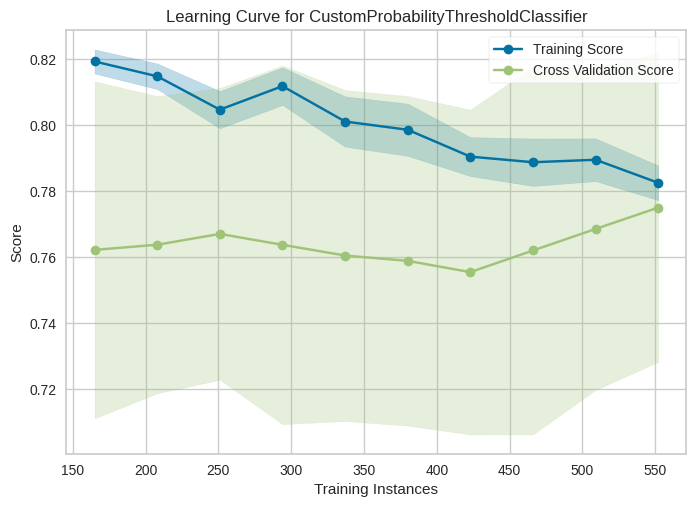

In [15]:
s.plot_model(majority_model, "learning")

In [36]:
majority_model_notuned = s.blend_models(best, optimize="MCC", fold=3, return_train_score=True, weights=list(weights))

In [17]:
majority_model_notuned = s.blend_models(best, optimize="MCC", fold=3, probability_threshold=0.65, return_train_score=True, weights=list(weights))
tuned_majority = s.tune_model(majority_model_notuned, fold=3, optimize='MCC', return_train_score=True, search_library="tune-sklearn", search_algorithm="hyperopt", early_stopping="asha")

2023-10-18 11:13:18,145	INFO tune.py:1148 -- Total run time: 11.07 seconds (7.76 seconds for the tuning loop).


In [18]:
s.save_model(majority_model, "../data/test_model")
loaded_model = s.load_model("../data/test_model")

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


In [19]:
X_test.drop("Class variable", axis=1)

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years)
613,6,105,80,28,0,32.5,0.878,26
399,3,193,70,31,0,34.9,0.241,25
38,2,90,68,42,0,38.2,0.503,27
703,2,129,0,0,0,38.5,0.304,41
75,1,0,48,20,0,24.7,0.140,22
...,...,...,...,...,...,...,...,...
633,1,128,82,17,183,27.5,0.115,22
747,1,81,74,41,57,46.3,1.096,32
523,9,130,70,0,0,34.2,0.652,45
405,2,123,48,32,165,42.1,0.520,26


In [25]:
best_dict = {key:model for key, model in enumerate(best)}
best_dict_split = {"split_1": best_dict, "split_2": best_dict}


In [39]:
majority_model

CustomProbabilityThresholdClassifier(classifier=VotingClassifier(estimators=[('Logistic '
                                                                              'Regression',
                                                                              LogisticRegression(C=9.473990064537498,
                                                                                                 class_weight='balanced',
                                                                                                 dual=False,
                                                                                                 fit_intercept=True,
                                                                                                 intercept_scaling=1,
                                                                                                 l1_ratio=None,
                                                                                                 max_iter=1000,
                                                                                                 multi_class='auto',
                                                                                                 n_jobs=None,
                                                                                                 penalty='l2',
                                                                                                 random_state=123,
                                                                                                 solver='lbfgs',
                                                                                                 tol=0.0001,
                                                                                                 verbose=0,
                                                                                                 warm_start=...
                                                                l1_ratio=0.8392216341132566,
                                                                learning_rate='adaptive',
                                                                loss='hinge',
                                                                max_iter=1000,
                                                                n_iter_no_change=5,
                                                                n_jobs=-1,
                                                                penalty='l2',
                                                                power_t=0.5,
                                                                random_state=123,
                                                                shuffle=True,
                                                                tol=0.001,
                                                                validation_fraction=0.1,
                                                                verbose=0,
                                                                warm_start=False))],
                                     flatten_transform=True, n_jobs=-1,
                                     probability_threshold=0.65, verbose=False,
                                     voting='hard',
                                     weights=array([0.33593731, 0.33306064, 0.33100205]))

In [40]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from pycaret.internal.meta_estimators import CustomProbabilityThresholdClassifier
isinstance(majority_model, CustomProbabilityThresholdClassifier)

True

In [50]:
majority_model.classifier

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=9.473990064537498,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('Linear Discriminant Analysis',
                              LinearDiscri...
                                            fit_intercept=True,
                                            l1_ratio=0.8392216341132566,
                                            learning_rate='adaptive',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=-1,
                                            penalty='l2', power_t=0.5,
                                            random_state=123, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False))],
                 flatten_transform=True, n_jobs=-1, verbose=False,
                 voting='hard',
                 weights=array([0.33593731, 0.33306064, 0.33100205]))

In [65]:
match best_dict_split:
    case {**name} if "split" in list(name)[0]:
        for key, value in name.items():
            for key in value:

        
    case CustomProbabilityThresholdClassifier():
        print("helo")
                

{'split_1': {0: CustomProbabilityThresholdClassifier(C=1.0, class_weight=None,
                                     classifier=LogisticRegression(C=1.0,
                                                                   class_weight=None,
                                                                   dual=False,
                                                                   fit_intercept=True,
                                                                   intercept_scaling=1,
                                                                   l1_ratio=None,
                                                                   max_iter=1000,
                                                                   multi_class='auto',
                                                                   n_jobs=None,
                                                                   penalty='l2',
                                                                   random_state=123,
          

In [30]:
s.predict_model(loaded_model, X_test.drop("Class variable", axis=1))

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),prediction_label
613,6,105,80,28,0,32.500000,0.878,26,0
399,3,193,70,31,0,34.900002,0.241,25,1
38,2,90,68,42,0,38.200001,0.503,27,0
703,2,129,0,0,0,38.500000,0.304,41,1
75,1,0,48,20,0,24.700001,0.140,22,0
...,...,...,...,...,...,...,...,...,...
633,1,128,82,17,183,27.500000,0.115,22,0
747,1,81,74,41,57,46.299999,1.096,32,0
523,9,130,70,0,0,34.200001,0.652,45,1
405,2,123,48,32,165,42.099998,0.520,26,1


In [ ]:
hold_out = s.predict_model(majority_model_notuned, probability_threshold=0.65, raw_score=True)
hold_out

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Average Precision Score
0,Voting Classifier,0.7987,0.7771,0.6897,0.7547,0.7207,0.5639,0.5653,0.6374


,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable,prediction_label
236,7,181,84,21,192,35.900002,0.586,51,1,1
395,2,127,58,24,275,27.700001,1.600,25,0,0
36,11,138,76,0,0,33.200001,0.420,35,0,1
210,2,81,60,22,0,27.700001,0.290,25,0,0
483,0,84,82,31,125,38.200001,0.233,23,0,0
...,...,...,...,...,...,...,...,...,...,...
650,1,91,54,25,100,25.200001,0.234,23,0,0
579,2,197,70,99,0,34.700001,0.575,62,1,1
119,4,99,76,15,51,23.200001,0.223,21,0,0
593,2,82,52,22,115,28.500000,1.699,25,0,0


In [ ]:
res = s.pull()
res

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Average Precision Score
0,Voting Classifier,0.7987,0.7771,0.6897,0.7547,0.7207,0.5639,0.5653,0.6374


In [14]:
plot_names = ["pipeline",
"auc", 
"threshold",
"pr", 
"confusion_matrix", 
"error", 
"class_report", 
"boundary", 
"rfe", 
"learning", 
"manifold", 
"calibration", 
"vc",
"dimension", 
"feature", 
"feature_all",
"parameter", 
"lift", 
"gain", 
"tree", 
"ks"]
important_plots = ["confusion_matrix", "learning", "class_report", "auc", "pr"]

In [156]:
load = s.load_model("classi_majority")

Transformation Pipeline and Model Successfully Loaded


In [93]:
s.predict_model(majority_model_notuned, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Average Precision Score
0,Voting Classifier,0.7403,0.7010,0.5636,0.6596,0.6078,0.4154,0.4183,0.5276


,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable,prediction_label
613,6,105,80,28,0,32.500000,0.878,26,0,0
399,3,193,70,31,0,34.900002,0.241,25,1,1
38,2,90,68,42,0,38.200001,0.503,27,1,0
703,2,129,0,0,0,38.500000,0.304,41,0,1
75,1,0,48,20,0,24.700001,0.140,22,0,0
...,...,...,...,...,...,...,...,...,...,...
633,1,128,82,17,183,27.500000,0.115,22,0,0
747,1,81,74,41,57,46.299999,1.096,32,0,0
523,9,130,70,0,0,34.200001,0.652,45,1,1
405,2,123,48,32,165,42.099998,0.520,26,0,1


In [94]:
res = s.pull()
res

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Average Precision Score
0,Voting Classifier,0.7403,0.701,0.5636,0.6596,0.6078,0.4154,0.4183,0.5276


In [99]:
dict(list(best_dict_split.items()))

{'split_1': {0: CustomProbabilityThresholdClassifier(C=1.0, class_weight=None,
                                       classifier=LogisticRegression(C=1.0,
                                                                     class_weight=None,
                                                                     dual=False,
                                                                     fit_intercept=True,
                                                                     intercept_scaling=1,
                                                                     l1_ratio=None,
                                                                     max_iter=1000,
                                                                     multi_class='auto',
                                                                     n_jobs=None,
                                                                     penalty='l2',
                                                                     random

In [92]:
s.predict_model(majority_model_notuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Average Precision Score
0,Voting Classifier,0.7403,0.7010,0.5636,0.6596,0.6078,0.4154,0.4183,0.5276


,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable,prediction_label
613,6,105,80,28,0,32.500000,0.878,26,0,0
399,3,193,70,31,0,34.900002,0.241,25,1,1
38,2,90,68,42,0,38.200001,0.503,27,1,0
703,2,129,0,0,0,38.500000,0.304,41,0,1
75,1,0,48,20,0,24.700001,0.140,22,0,0
...,...,...,...,...,...,...,...,...,...,...
633,1,128,82,17,183,27.500000,0.115,22,0,0
747,1,81,74,41,57,46.299999,1.096,32,0,0
523,9,130,70,0,0,34.200001,0.652,45,1,1
405,2,123,48,32,165,42.099998,0.520,26,0,1


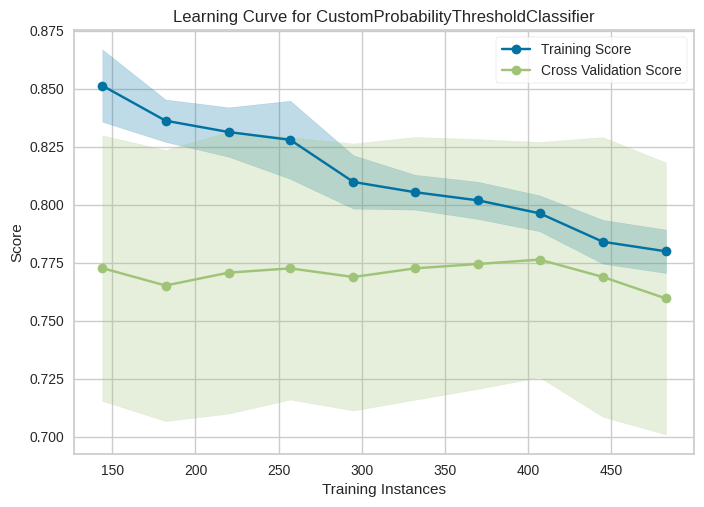

In [20]:
s.plot_model(majority_model, plot="learning")

## Regression

In [74]:
data_reg = get_data('insurance')

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [75]:
exp = RegressionExperiment()
exp.setup(data=data_reg, target='charges', normalize=True, normalize_method='zscore', log_experiment=True, experiment_name="Regression", log_data=True, log_plots=True)

,Description,Value
0,Session id,6513
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1338, 10)"
5,Transformed train set shape,"(936, 10)"
6,Transformed test set shape,"(402, 10)"
7,Ordinal features,2
8,Numeric features,3
9,Categorical features,3


In [76]:
mod = exp.models()
interested = mod.drop(["tr", "kr", "ransac", "ard", "ada", "lightgbm"]).index.to_list()
mod

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [77]:
# compare baseline models
# For scoring, it create 10 models (1 for each fold). This improves the odds of making sure that the metrics are reproducible when we get new data. Then the model that is returned (single model) is trained on all the training data (all folds combined)
best_reg = exp.compare_models(n_select=3, fold=3, budget_time=2, include=interested)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2824.4673,24058108.2996,4889.6410,0.8352,0.4674,0.3358,0.0433
rf,Random Forest Regressor,2955.5017,26298822.5176,5118.6850,0.8204,0.5012,0.3643,0.0900
catboost,CatBoost Regressor,3003.7999,27015002.8545,5186.3877,0.8148,0.5323,0.3602,0.3733
et,Extra Trees Regressor,3005.2845,29158752.8494,5393.2099,0.7992,0.5289,0.3970,0.0833
xgboost,Extreme Gradient Boosting,3311.2249,31660958.6667,5615.1938,0.7834,0.6227,0.4233,0.0400
knn,K Neighbors Regressor,3806.3279,34843978.0000,5895.7915,0.7607,0.5176,0.4070,0.0267
lr,Linear Regression,4377.5184,38810354.0085,6222.1388,0.7339,0.5902,0.4483,0.4133
ridge,Ridge Regression,4392.4981,38841805.5409,6224.5165,0.7336,0.5920,0.4520,0.3267
lasso,Lasso Regression,4389.8028,38841916.1803,6224.5065,0.7336,0.5909,0.4514,0.3233
br,Bayesian Ridge,4397.4443,38845865.5635,6224.8671,0.7336,0.6244,0.4532,0.0300


In [78]:
exp.create_model(interested[0], return_train_score=True)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, positive=False)

In [79]:
res = exp.pull()

In [80]:
res.loc[("CV-Train", "Mean")]

MAE      4.313992e+03
MSE      3.770049e+07
RMSE     6.139863e+03
R2       7.445000e-01
RMSLE    6.073000e-01
MAPE     4.383000e-01
Name: (CV-Train, Mean), dtype: float64

In [81]:
results_compare_reg = exp.pull()

In [82]:
weights_reg = softmax(results_compare_reg.R2[:3].values)
weights_reg

array([0.33503483, 0.33166801, 0.33329717])

In [84]:
results_reg = {}
tuned_top_reg = []
for i, model in enumerate(best_reg):
    tuned_top_reg.append(exp.tune_model(model, fold=3, optimize='R2', return_train_score=True, search_library="tune-sklearn", search_algorithm="hyperopt", early_stopping="asha", choose_better=True))
    results_reg[f"tuned_{i}"] = exp.pull()
majority_model_reg = exp.blend_models(tuned_top_reg, optimize="R2", fold=3, return_train_score=True, weights=weights_reg)
results_reg["majority_model"] = exp.pull()
stacked_model_reg = exp.stack_models(tuned_top_reg, optimize="R2", fold=3, return_train_score=True)
results_reg["stacked_model"] = exp.pull()
#best_r2_model = exp.automl(optimize ='R2')
#results_rec["best_r2_model"] = exp.pull()


2023-10-18 12:34:41,071	INFO tune.py:1148 -- Total run time: 15.18 seconds (12.74 seconds for the tuning loop).


In [83]:
plot_names_reg = ["pipeline", 
"residuals_interactive",
"residuals",
"cooks",
"error", 
"rfe", 
"learning", 
"manifold", 
"vc",
"feature", 
"feature_all",
"parameter", 
"tree", ]
important_plots = ["residuals", "error", "learning"]

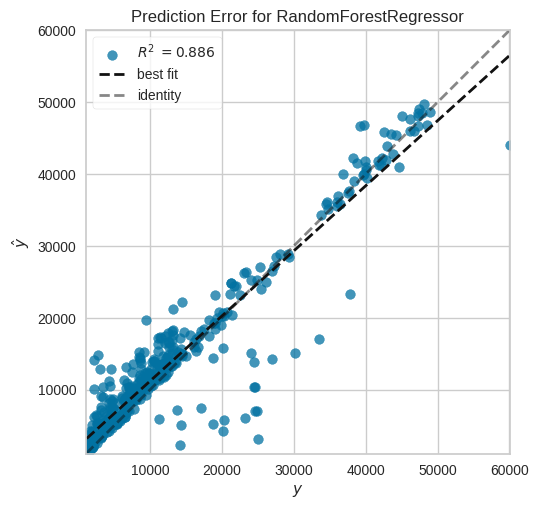

In [75]:
exp.plot_model(best_reg[1], plot="error")

In [50]:
majority_model_reg.named_estimators['Gradient Boosting Regressor'].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 7134,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [66]:
r = majority_model.get_params()["estimators"][0][1]

In [70]:
exp.save_model(majority_model_reg, "out/majority_model_reg")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'bmi', 'children'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     include...
                                                                     min_impur

In [76]:
new_data = data_reg.drop("charges", axis=1)
new_data.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [78]:
trained = exp.load_model("majority_model_reg")
trained.predict_proba(new_data)

Transformation Pipeline and Model Successfully Loaded


AttributeError: 'VotingRegressor' object has no attribute 'predict_proba'